# Locomotion Mode Classification Using RNN Architectures

## Imports

In [3]:
import numpy as np
from scipy.io import loadmat, savemat
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten
from keras.layers import SimpleRNN, LSTM, GRU, TimeDistributed, BatchNormalization
from keras.losses import categorical_crossentropy
from keras import regularizers
import keras.backend as K
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import Sequence, to_categorical, plot_model
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.manifold import TSNE
from imu_preprocess_utils import *
#import tsne as tsne

/usr/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


## Read dataset and preprocess

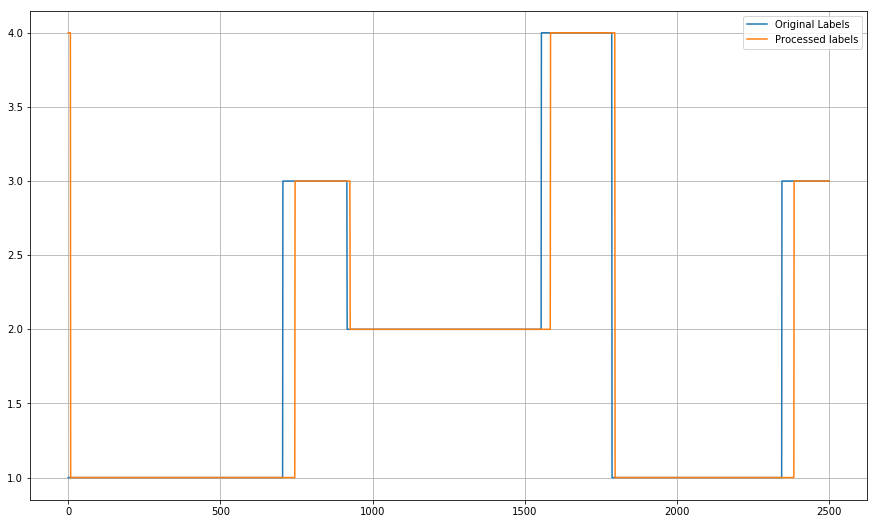

X_test  (20950, 63)
X_train  (67897, 63)
Y_test (20950, 6) max: 1.0, min:0.0
Y_train (67897, 6) max: 1.0, min:0.0


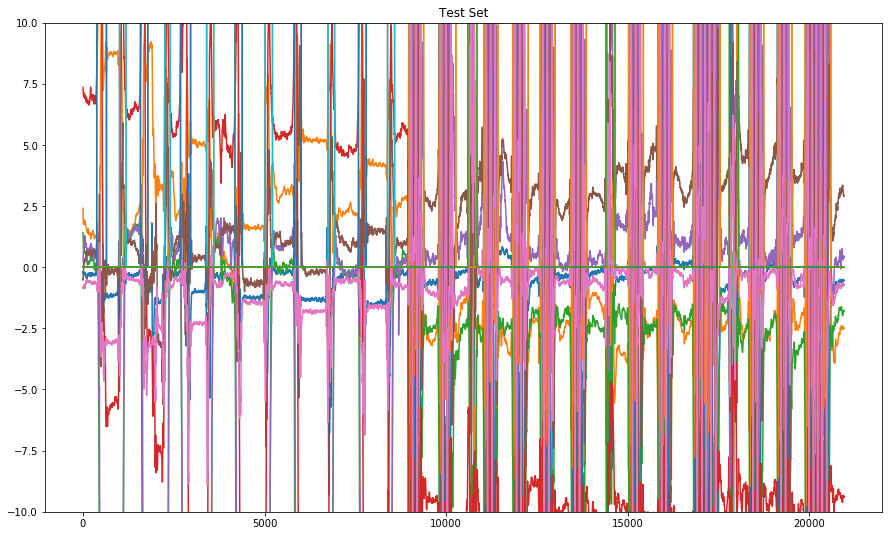

Training:  (67817, 80, 63) (67817, 80, 6)
Testing:  (20870, 80, 63) (20870, 80, 6)


In [23]:
# Read sit-stand data from file
sit_stand_data = loadmat('../Datasets/ashwin_testdata/sit_stand_data_labeled.mat')
walk_data = loadmat('../Datasets/ashwin_testdata/walk_data_ashwin.mat')

# Some (hyper?) parameters
BATCH_SIZE = 32
SEQUENCE_LENGTH = 80 # Length of subsequences to split into
DEFAULT_DELAY = 20
NFEAT = 63

# Normalization constants.
scale_factors = np.array([9.8, 9.8, 9.8, 9.8, 200, 200, 200, 200]*7 + [20.0]*7)

# Transition delays. These delays are added to each transition between modes.
TD = {'1': {'3': 40},
      '2': {'4': 30, '5': 30, '6': 10},
      '3': {'2': 10},
      '4': {'1': 10},
      '5': {'2': -10},
      '6': {'1': 0, '2':-10}}

# Take one 90 seconds of data from the sit-stand and 2 minutes from the walking data for Testing.
tmp_x = sit_stand_data['features']
tmp_y = sit_stand_data['labels'].flatten()
# Sit-Stand test set
X_test = tmp_x[tmp_x.shape[0]-8950:, :]
Y_test = tmp_y[tmp_x.shape[0]-8950:]
# Sit-Stand training set
X_train = tmp_x[:tmp_x.shape[0]-8950, :]
Y_train = tmp_y[:tmp_x.shape[0]-8950]
#Y_train[12692] = Y_train[12691]

tmp_x = walk_data['features']
tmp_y = walk_data['labels'].flatten()

# Total test set
X_test = np.vstack((X_test, tmp_x[tmp_x.shape[0]-12000:]))
Y_test = np.append(Y_test, tmp_y[tmp_y.shape[0]-12000:])
#Y_test = np.vstack((Y_test, to_categorical(tmp_y[tmp_y.shape[0]-12000:])))

# Total training set
X_train = np.vstack((X_train, tmp_x[:tmp_x.shape[0]-12000, :]))
Y_train = np.append(Y_train, tmp_y[:tmp_y.shape[0]-12000])
#Y_train = np.vstack((Y_train, tmp_y[:tmp_x.shape[0]-12000, :]))
#Y_train[np.argwhere(Y_train==0)] = 2

# Normalize the features
#X_train = X_train/scale_factors
#X_test = X_test/scale_factors
    


#print(np.argwhere(Y_train == 0))
# Add appropriate delays in the transitions
Y_train_prep = add_transition_delays(Y_train, TD)
Y_test_prep = add_transition_delays(Y_test, TD)
                
## Plot to check
ST = 6000
EN = 8500
plt.figure(figsize=(15, 9))
plt.plot(Y_test[ST:EN], label='Original Labels')
#plt.plot(X_train[ST:EN, 56:])
plt.plot(Y_test_prep[ST:EN], label='Processed labels')
plt.grid()
plt.legend()
plt.show()
    
# Convert to categorical variables
Y_train_prep = to_categorical(Y_train_prep-1)
Y_test_prep = to_categorical(Y_test_prep-1)

# using t-SNE for a low dimensional representation
# colors = ['red', 'blue', 'green', 'pink', 'orange', 'gray']
# color_array = [colors[c] for c in np.argmax(Y_test_prep, axis=1)]
# rows = [i for i in range(6000, 13000)]
# print("X_train.shape={}".format(X_train.shape))
# X_tsne = TSNE(n_components=2, perplexity=50).fit_transform(X_test[rows, :])
# Y_tsne = np.argmax(Y_test_prep[rows, :], axis=1)
# plt.figure(figsize=(15, 9))
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 10, color=color_array)
# plt.grid()

print("X_test ", X_test.shape)
print("X_train ", X_train.shape)
print("Y_test {} max: {}, min:{}".format(Y_test_prep.shape, np.max(Y_test_prep), np.min(Y_test_prep)))
print("Y_train {} max: {}, min:{}".format(Y_train_prep.shape, np.max(Y_train_prep), np.min(Y_train_prep)))
#print(np.argwhere(Y_train == 0))

plt.figure(figsize=(15, 9))
plt.title("Test Set")
plt.plot(X_test[:, 56:])
plt.plot(Y_test_prep*10)
plt.ylim([-10, 10])
plt.show()

# Do dimensionality reduction on the dataset
TrainingSetPCA = PCA(n_components=30)
TrainingSetPCA.fit(X_train)
X_train_pca = TrainingSetPCA.transform(X_train)
X_test_pca = TrainingSetPCA.transform(X_test)

# Save data to mat file
#savemat('preprocessed_data_ashwin.mat', {'X_train': X_train, 'Y_train': Y_train_prep,
#                                         'X_test': X_test, 'Y_test_prep': Y_test_prep})

# Make a sequence object from the data 
class IMUSeq(Sequence):
    def __init__(self, xin, yin, length=100, stride=1, batch_size=64):
        self.X = xin
        self.Y = yin
        self.dset_gen = TimeseriesGenerator(xin, yin, length=length, batch_size=batch_size)
    def __len__(self):
        return len(self.dset_gen)
    def __getitem__(self, idx):
        #idxs = [i for i in range(idx*self.length, (idx+1)*self.length)]
        #x_seq = self.X[idx*self.length:(idx+1)*self.length, :]
        #y_seq = self.Y[idx*self.length:(idx+1)*self.length, :]
        #X_seq = np.zeros((self.batch_size, self.length, self.X.shape[1]))
        #Y_seq = np.zeros((self.batch_size, self.length, self.Y.shape[1]))
        X_batch, Y_batch = self.dset_gen[idx]
        
        return (X_batch, Y_batch)

#train_ts = IMUSeq(X_train, Y_train, length=SEQUENCE_LENGTH)
#train_ts = IMUSeq(X_train, Y_train, length=SEQUENCE_LENGTH)
#print(train_ts[0][0].shape)
#print(train_ts[0][1].shape)

X_seq_train, Y_seq_train = get_sub_sequences(X_train, Y_train_prep, 
                                             window_size=SEQUENCE_LENGTH, 
                                             step_size=1, seq_out=True)


X_seq_test, Y_seq_test   = get_sub_sequences(X_test, Y_test_prep, 
                                             window_size=SEQUENCE_LENGTH, 
                                             step_size=1, seq_out=True)
print("Training: ", X_seq_train.shape, Y_seq_train.shape)
print("Testing: ", X_seq_test.shape, Y_seq_test.shape)
#print(train_ts[0])



(67817, 80, 63)


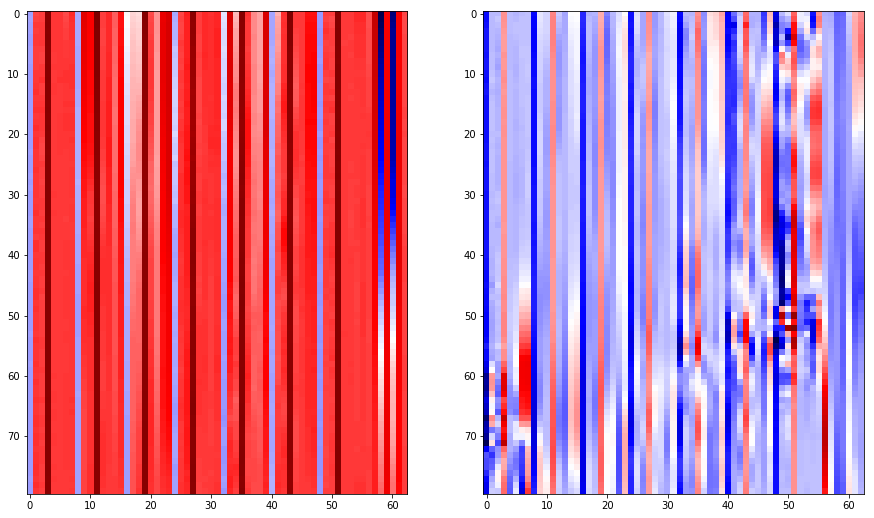

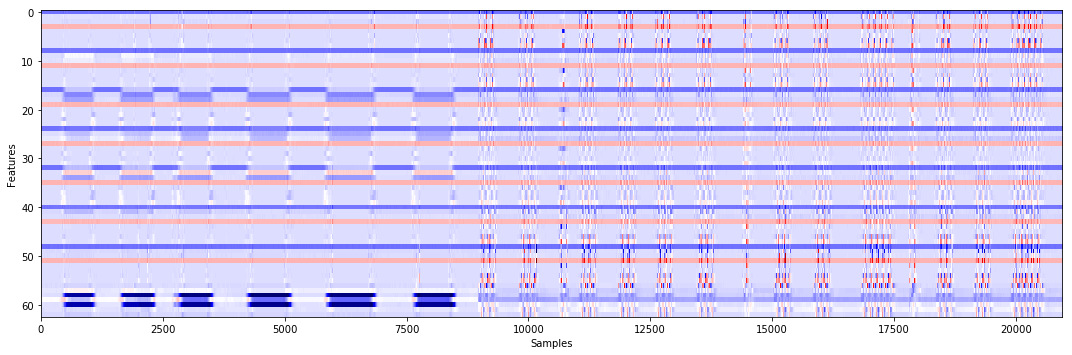

In [54]:
# Plot some of the windows for the presentation
print(X_seq_train.shape)
#plt.figure(figsize=(15, 9))
#scale_factors2 = np.abs(X_train)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 9))
ax1.imshow(X_seq_train[750, :, :]/scale_factors, cmap='seismic')
ax2.imshow(X_seq_train[67050, :, :]/scale_factors, cmap='seismic')
plt.savefig('Windows.png')

plt.figure(figsize=(15, 9))
plt.imshow((X_test/scale_factors).T, aspect=100, cmap='seismic')
plt.ylabel('Features')
plt.xlabel('Samples')
plt.tight_layout()
plt.savefig('imu_full_visualization.png')

plt.show()

## Test using plain logistic regression

In [7]:
lgr_model = Sequential()
lgr_model.add(Dense(units=45, activation='relu', input_dim=X_train_pca.shape[1],
                    kernel_regularizer=regularizers.l2(0.01)))
#lgr_model.add(Dense(units=45, activation='relu', input_dim=X_train.shape[1],
#                    kernel_regularizer=regularizers.l2(0.01)))
lgr_model.add(Dense(units=24, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01)))
lgr_model.add(Dense(units=12, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01)))
lgr_model.add(Dense(units=6, activation='softmax'))
lgr_model.compile(optimizer='adam',
                  loss='kullback_leibler_divergence',
                  metrics=['accuracy'])
lgr_model.summary()
lgr_model.fit(X_train_pca, Y_train_prep, epochs=50,
                validation_data=(X_test_pca, Y_test_prep))
lgr_model.fit(X_train, Y_train_prep, epochs=50,
                validation_data=(X_test_pca, Y_test_prep))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 45)                1395      
_________________________________________________________________
dense_6 (Dense)              (None, 24)                1104      
_________________________________________________________________
dense_7 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 78        
Total params: 2,877
Trainable params: 2,877
Non-trainable params: 0
_________________________________________________________________
Train on 67897 samples, validate on 20950 samples
Epoch 1/50
67897/67897 [==============================] - 2s 31us/step - loss: 0.9444 - acc: 0.9086 - val_loss: 0.4964 - val_acc: 0.9364
Epoch 2/50
67897/67897 [==============================] - 2s 29us/step - loss: 0.3658

KeyboardInterrupt: 

In [ ]:
#preds = lgr_model.predict(X_test)
preds = to_categorical(lgr_model.predict_classes(X_test_pca))
tvals = np.arange(0, preds.shape[0])

plot_model(lgr_model, to_file='DeepNN.png', show_shapes=True)

# Filtering using viterbi?
preds_viterbi = np.zeros(preds.shape)
# Transition probabilities.
A = np.array([[0.95, 0.00, 0.05, 0.00, 0.00, 0.00],
              [0.00, 0.90, 0.00, 0.05, 0.04, 0.01],
              [0.01, 0.10, 0.89, 0.00, 0.00, 0.00],
              [0.10, 0.01, 0.01, 0.88, 0.00, 0.00],
              [0.00, 0.10, 0.00, 0.00, 0.89, 0.01],
              [0.01, 0.05, 0.01, 0.01, 0.02, 0.90]])
T1 = np.zeros(preds.shape)
T2 = np.zeros((preds.shape[0],))
T1[0, :] = np.array([0., 1., 0., 0., 0., 0.])
T2[0] = 1
for i in range(1, preds.shape[0]):
    # Transition the probability forward.
    probs = np.dot(T1[i-1, :], A)*preds[i, :]
    # Normalize the probabilities
    probs = probs/np.sum(probs)
    T1[i, :] = probs
    T2[i] = np.argmax(probs)
viterbi_preds = T2#to_categorical(T2)
viterbi_accuracy = np.sum(np.array(viterbi_preds == np.argmax(Y_test_prep, axis=1), dtype=int))/preds.shape[0]
print("Viterbi Accuracy: {}".format(viterbi_accuracy))
              
print(preds.shape, tvals.shape, X_test.shape)
PLT_RANGE = [i for i in range(100, 19000)]
plt.figure(figsize=(15,9))
plt.title("Locomotion Mode Predictions using Logistic Regression")
plt.xlabel('Sample')
plt.plot(tvals[PLT_RANGE], X_test[PLT_RANGE, 56], label='Right Foot Tilt')
plt.plot(tvals[PLT_RANGE], X_test[PLT_RANGE, 57], label='Right Shank Tilt')
plt.plot(tvals[PLT_RANGE], X_test[PLT_RANGE, 58], label='Right Thigh Tilt')
plt.plot(tvals[PLT_RANGE], preds[PLT_RANGE, 0]*100, label='Sit')
plt.fill_between(tvals[PLT_RANGE], 0, preds[PLT_RANGE, 0]*100, alpha=0.3, facecolor='red')
plt.plot(tvals[PLT_RANGE], preds[PLT_RANGE, 1]*100, label='Stand')
plt.fill_between(tvals[PLT_RANGE], 0, preds[PLT_RANGE, 1]*100, alpha=0.3, facecolor='violet')
plt.plot(tvals[PLT_RANGE], preds[PLT_RANGE, 2]*100, label='Rise')
plt.fill_between(tvals[PLT_RANGE], 0, preds[PLT_RANGE, 2]*100, alpha=0.3, facecolor='brown')
plt.plot(tvals[PLT_RANGE], preds[PLT_RANGE, 3]*100, label='Down')
plt.fill_between(tvals[PLT_RANGE], 0, preds[PLT_RANGE, 3]*100, alpha=0.3, facecolor='pink')
plt.plot(tvals[PLT_RANGE], preds[PLT_RANGE, 4]*100, label='Walk')
plt.fill_between(tvals[PLT_RANGE], 0, preds[PLT_RANGE, 4]*100, alpha=0.3, facecolor='gray')
plt.plot(tvals[PLT_RANGE], preds[PLT_RANGE, 5]*100, label='Unknown')
plt.fill_between(tvals[PLT_RANGE], 0, preds[PLT_RANGE, 5]*100, alpha=0.3, facecolor='yellow')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('logistic_regression_prediction.png')
plt.show()

### Decision Trees

In [ ]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, Y_train_prep)
acc = dt_clf.score(X_test, Y_test_prep)
print("Decision Trees: {}".format(acc))

## Classify using RNN

### Model 1

In [9]:
# Build model
model1 = Sequential()
# model1.add(Input((None, 63)))
# model1.add(TimeDistributed(Dense(32, activation='relu')))
model1.add(SimpleRNN(units=45, activation='relu', 
                     return_sequences=True,
                     kernel_regularizer=regularizers.l2(0.01),
                     bias_regularizer=regularizers.l2(0.01),
                     recurrent_regularizer=regularizers.l2(0.01),
                     input_shape=(None, X_train.shape[1])))
model1.add(BatchNormalization())
model1.add(SimpleRNN(units=24, activation='relu', 
                     return_sequences=True,
                     kernel_regularizer=regularizers.l2(0.01),
                     bias_regularizer=regularizers.l2(0.01),
                     recurrent_regularizer=regularizers.l2(0.01)))
#model1.add(BatchNormalization())
model1.add(SimpleRNN(units=12, activation='relu', 
                     return_sequences=True,
                     kernel_regularizer=regularizers.l2(0.01),
                     bias_regularizer=regularizers.l2(0.01),
                     recurrent_regularizer=regularizers.l2(0.01)))
#model1.add(BatchNormalization())
model1.add(SimpleRNN(units=6, activation='softmax', 
                     return_sequences=True,
                     kernel_regularizer=regularizers.l2(0.01),
                     bias_regularizer=regularizers.l2(0.01),
                     recurrent_regularizer=regularizers.l2(0.01)))
# model1.add(LSTM(units=42, activation='relu', 
#                      return_sequences=True,
#                      kernel_regularizer=regularizers.l2(0.01),
#                      bias_regularizer=regularizers.l2(0.01),
#                      recurrent_regularizer=regularizers.l2(0.01),
#                      input_shape=(None, X_train.shape[1])))
# model1.add(Dense(8, activation='relu'))
#model1.add(Dense(6, activation='softmax'))


# Custom loss function that includes transition term
def custom_loss(y_true, y_pred):
    term1 = categorical_crossentropy(y_true, y_pred)
    term2 = K.sum(y_true*(1-y_pred))
    
    return term1 + 0.2*term2
    
    

model1.compile(optimizer='adam', 
               loss='kullback_leibler_divergence',
               metrics=['accuracy'])
# model1.compile(optimizer='adam', 
#                loss='categorical_crossentropy',
#                metrics=['accuracy'])
#print("Model 1 Summary:")
#model1.summary()
#print(model1.weights)

# Train model
print("Training:")
model1.fit(X_seq_train, Y_seq_train, epochs=10, batch_size=256,
          validation_data=(X_seq_test, Y_seq_test))

print("Model 1 Summary:")
model1.summary()
print(model1.weights)
#model1.fit_generator(train_ts, epochs=5)

# for data_batch in train_ts:
#     X_batch = data_batch[0]
#     Y_batch = data_batch[1]
#     model1.train_on_batch(X_batch, Y_batch)

Training:
Train on 67817 samples, validate on 20870 samples
Epoch 1/10
67817/67817 [==============================] - 25s 374us/step - loss: 1.7710 - acc: 0.8044 - val_loss: 1.0250 - val_acc: 0.9295
Epoch 2/10
67817/67817 [==============================] - 24s 361us/step - loss: 0.6805 - acc: 0.9592 - val_loss: 0.6308 - val_acc: 0.9320
Epoch 3/10
67817/67817 [==============================] - 24s 361us/step - loss: 0.4318 - acc: 0.9673 - val_loss: 0.4402 - val_acc: 0.9534
Epoch 4/10
67817/67817 [==============================] - 25s 362us/step - loss: 0.3317 - acc: 0.9710 - val_loss: 0.3769 - val_acc: 0.9518
Epoch 5/10
67817/67817 [==============================] - 24s 361us/step - loss: 0.2859 - acc: 0.9726 - val_loss: 0.3478 - val_acc: 0.9533
Epoch 6/10
67817/67817 [==============================] - 24s 361us/step - loss: 0.2562 - acc: 0.9741 - val_loss: 0.3148 - val_acc: 0.9561
Epoch 7/10
67817/67817 [==============================] - 25s 362us/step - loss: 0.2370 - acc: 0.9756 - va

[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]] (20950, 6)
(20950, 6) (20950,) (20950, 63)


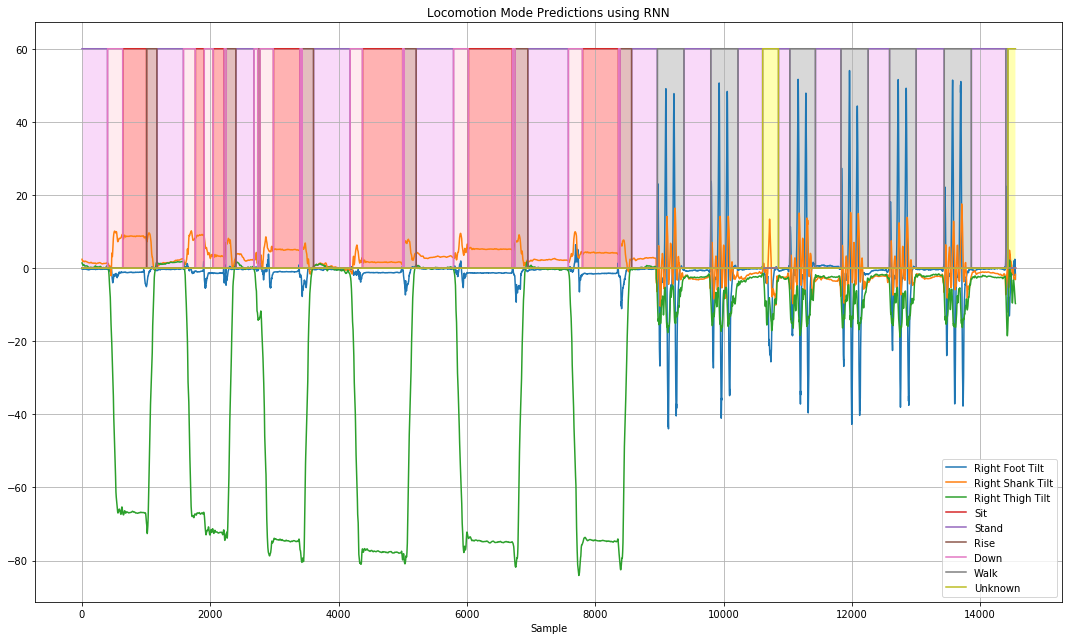

In [14]:
#preds = lgr_model.predict(X_test)
preds = to_categorical(model1.predict_classes(np.reshape(X_test, (1,X_test.shape[0], X_test.shape[1]))))
preds = np.reshape(preds, (preds.shape[1], preds.shape[2]))
print(preds, preds.shape)
tvals = np.arange(0, preds.shape[0])
print(preds.shape, tvals.shape, X_test.shape)
PLT_RANGE = [i for i in range(0, 14550)]
plt.figure(figsize=(15,9))
plt.title("Locomotion Mode Predictions using RNN")
plt.xlabel('Sample')
plt.plot(tvals[PLT_RANGE], X_test[PLT_RANGE, 56], label='Right Foot Tilt')
plt.plot(tvals[PLT_RANGE], X_test[PLT_RANGE, 57], label='Right Shank Tilt')
plt.plot(tvals[PLT_RANGE], X_test[PLT_RANGE, 58], label='Right Thigh Tilt')

plt.plot(tvals[PLT_RANGE], preds[PLT_RANGE, 0]*60, label='Sit')
plt.fill_between(tvals[PLT_RANGE], 0, preds[PLT_RANGE, 0]*60, alpha=0.3, facecolor='red')
plt.plot(tvals[PLT_RANGE], preds[PLT_RANGE, 1]*60, label='Stand')
plt.fill_between(tvals[PLT_RANGE], 0, preds[PLT_RANGE, 1]*60, alpha=0.3, facecolor='violet')
plt.plot(tvals[PLT_RANGE], preds[PLT_RANGE, 2]*60, label='Rise')
plt.fill_between(tvals[PLT_RANGE], 0, preds[PLT_RANGE, 2]*60, alpha=0.3, facecolor='brown')
plt.plot(tvals[PLT_RANGE], preds[PLT_RANGE, 3]*60, label='Down')
plt.fill_between(tvals[PLT_RANGE], 0, preds[PLT_RANGE, 3]*60, alpha=0.3, facecolor='pink')
plt.plot(tvals[PLT_RANGE], preds[PLT_RANGE, 4]*60, label='Walk')
plt.fill_between(tvals[PLT_RANGE], 0, preds[PLT_RANGE, 4]*60, alpha=0.3, facecolor='gray')
plt.plot(tvals[PLT_RANGE], preds[PLT_RANGE, 5]*60, label='Unknown')
plt.fill_between(tvals[PLT_RANGE], 0, preds[PLT_RANGE, 5]*60, alpha=0.3, facecolor='yellow')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('RNN_predictions.png')
plt.show()

plot_model(model1, to_file='RNN.png', show_shapes=True)

### Model 2

In [ ]:
# Build model
model1 = Sequential()
# model1.add(Input((None, 63)))
# model1.add(TimeDistributed(Dense(32, activation='relu')))
model1.add(GRU(units=42, activation='relu', 
                     return_sequences=True,
                     kernel_regularizer=regularizers.l2(0.01),
                     bias_regularizer=regularizers.l2(0.01),
                     recurrent_regularizer=regularizers.l2(0.01),
                     input_shape=(None, X_train.shape[1])))
#model1.add(BatchNormalization())
model1.add(GRU(units=21, activation='relu', 
                     return_sequences=True,
                     kernel_regularizer=regularizers.l2(0.01),
                     bias_regularizer=regularizers.l2(0.01),
                     recurrent_regularizer=regularizers.l2(0.01)))
#model1.add(BatchNormalization())
#model1.add(GRU(units=10, activation='relu', 
#                     return_sequences=True,
#                     kernel_regularizer=regularizers.l2(0.01),
#                     bias_regularizer=regularizers.l2(0.01),
#                     recurrent_regularizer=regularizers.l2(0.01)))
#model1.add(BatchNormalization())
model1.add(GRU(units=6, activation='softmax', 
                     return_sequences=True,
                     kernel_regularizer=regularizers.l2(0.01),
                     bias_regularizer=regularizers.l2(0.01),
                     recurrent_regularizer=regularizers.l2(0.01)))
# model1.add(LSTM(units=42, activation='relu', 
#                      return_sequences=True,
#                      kernel_regularizer=regularizers.l2(0.01),
#                      bias_regularizer=regularizers.l2(0.01),
#                      recurrent_regularizer=regularizers.l2(0.01),
#                      input_shape=(None, X_train.shape[1])))
# model1.add(Dense(8, activation='relu'))
#model1.add(Dense(6, activation='softmax'))


# Custom loss function that includes transition term
def custom_loss(y_true, y_pred):
    term1 = categorical_crossentropy(y_true, y_pred)
    


model1.compile(optimizer='adam', 
               loss='categorical_crossentropy',
               metrics=['accuracy'])
#print("Model 1 Summary:")
#model1.summary()
#print(model1.weights)

# Train model
print("Training:")
model1.fit(X_seq_train, Y_seq_train, epochs=40, batch_size=128,
          validation_data=(X_seq_test, Y_seq_test))

print("Model 1 Summary:")
model1.summary()
print(model1.weights)
#model1.fit_generator(train_ts, epochs=5)

In [ ]:
#preds = lgr_model.predict(X_test)
preds = to_categorical(model1.predict_classes(np.reshape(X_test, (1,X_test.shape[0], X_test.shape[1]))))
preds = np.reshape(preds, (preds.shape[1], preds.shape[2]))
print(preds, preds.shape)
tvals = np.arange(0, preds.shape[0])
print(preds.shape, tvals.shape, X_test.shape)
PLT_RANGE = [i for i in range(3000, 10050)]
plt.figure(figsize=(15,9))
plt.title("Locomotion Mode Predictions using RNN")
plt.xlabel('Sample')
plt.plot(tvals[PLT_RANGE], X_test[PLT_RANGE, 56]*10, label='Right Foot Tilt')
plt.plot(tvals[PLT_RANGE], X_test[PLT_RANGE, 57]*10, label='Right Shank Tilt')
plt.plot(tvals[PLT_RANGE], X_test[PLT_RANGE, 58]*10, label='Right Thigh Tilt')
plt.plot(tvals[PLT_RANGE], preds[PLT_RANGE, 0]*100, label='Sit')

plt.fill_between(tvals[PLT_RANGE], 0, preds[PLT_RANGE, 0]*100, alpha=0.3, facecolor='red')
plt.plot(tvals[PLT_RANGE], preds[PLT_RANGE, 1]*100, label='Stand')
plt.fill_between(tvals[PLT_RANGE], 0, preds[PLT_RANGE, 1]*100, alpha=0.3, facecolor='violet')
plt.plot(tvals[PLT_RANGE], preds[PLT_RANGE, 2]*100, label='Rise')
plt.fill_between(tvals[PLT_RANGE], 0, preds[PLT_RANGE, 2]*100, alpha=0.3, facecolor='brown')
plt.plot(tvals[PLT_RANGE], preds[PLT_RANGE, 3]*100, label='Down')
plt.fill_between(tvals[PLT_RANGE], 0, preds[PLT_RANGE, 3]*100, alpha=0.3, facecolor='pink')
plt.plot(tvals[PLT_RANGE], preds[PLT_RANGE, 4]*100, label='Walk')
plt.fill_between(tvals[PLT_RANGE], 0, preds[PLT_RANGE, 4]*100, alpha=0.3, facecolor='gray')
plt.plot(tvals[PLT_RANGE], preds[PLT_RANGE, 5]*100, label='Unknown')
plt.fill_between(tvals[PLT_RANGE], 0, preds[PLT_RANGE, 5]*100, alpha=0.3, facecolor='yellow')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('RNN_predictions.png')
plt.show()

### Model 3

In [ ]:
# Build model
model2 = Sequential()
model2.add(Conv2D(filters=31, kernel_size=(SEQUENCE_LENGTH, 1), 
                  input_shape=(SEQUENCE_LENGTH, NFEAT, 1), activation='relu',
                  data_format='channels_last'))
#model2.add(Conv2D(filters=5, kernel_size=(SEQUENCE_LENGTH, 1), activation='relu'))
model2.add(Flatten())
model2.add(Dense(6, activation='softmax'))
model2.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model2.fit(X_seq_train, Y_seq_train, epochs=40, batch_size=128,
          validation_data=(X_seq_test, Y_seq_test))
model2.summary()